In [41]:
import matplotlib
matplotlib.use('nbagg')
print(matplotlib.get_backend())

import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv

nbAgg


In [42]:
#loading dataset 
dataset_location = 'C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/images'
L = os.listdir(dataset_location)
L.sort()

In [43]:
#ground Truth
ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/poses.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:400,3]
gz = ground_truth[:400,11]

In [44]:
#calibration matrix

k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
             [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])


In [53]:
def keypoints(img):
    
    fast = cv.FastFeatureDetector_create()
    fast.setNonmaxSuppression(1)
    fast.setThreshold(60)
    kp = fast.detect(img,None)
    """
    sift = cv.SIFT_create()
    kp, des1 = sift.detectAndCompute(img1,None)
    print(len(kp))
     """
    pt = np.float32([ kp[m].pt for m in range(len(kp))]).reshape(-1,1,2)
   
    return kp,pt  

In [54]:
def optical_flow_matches(img,trig_frame,pt1,window_size):
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (window_size,window_size),
                      maxLevel = 2,
                      criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    ptimg, st, err = cv.calcOpticalFlowPyrLK(trig_frame, img, pt1, None, **lk_params)
    #ptimgst = ptimg[st.ravel()==1].reshape((-1,1,2))
    pt1i, st, err = cv.calcOpticalFlowPyrLK(img, trig_frame, ptimg, None, **lk_params)
    #pt1ist = pt1i[st.ravel()==1].reshape(-1,1,2)
    return ptimg,pt1i#,ptimgst,pt1ist

In [55]:
def point3D(k,R1,R2,t1,t2,pts1,pts2):
    rt = np.zeros((3,4))
    rt[:3,:3] = R1
    rt[:,3] = t1.reshape((3))
    projMatr1 = k@rt
    rt2 = np.zeros((3,4))
    rt2[:3,:3] = R2
    rt2[:,3] = t2.reshape((3))
    projMatr2 = k@rt2
    points4D = cv.triangulatePoints(projMatr1,projMatr2,pts1 ,pts2)
    points3D = points4D / points4D[3,:]
    return points3D.T[:,:3]

In [56]:
def reprojection_error(pointcloud,R3,t3,kp3):
    p3d = np.ones((4,pointcloud.shape[0]))
    p3d[:3,:] = pointcloud.T
    projection_mat = np.zeros((3,4))
    projection_mat[:3,:3] = R3
    projection_mat[:,3] = t3.reshape((3))
    proj_pt = k@projection_mat@p3d
    proj_pt = proj_pt.T
    proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
    proj_pt = proj_pt[:,:2]
    err = proj_pt - kp3.reshape((-1,2))
    norm_err = np.linalg.norm(err, axis=1)
    return np.min(norm_err)

In [57]:
def RelativeScale1(last_cloud, new_cloud):
    min_idx = min([new_cloud.shape[0],last_cloud.shape[0]])
    p_Xk = new_cloud[:min_idx]
    Xk = np.roll(p_Xk,shift = -10)
    p_Xk_1 = last_cloud[:min_idx]
    Xk_1 = np.roll(p_Xk_1,shift = -10)
    d_ratio = (np.linalg.norm(p_Xk_1 - Xk_1,axis = -1))/(np.linalg.norm(p_Xk - Xk,axis = -1))

    return np.median(d_ratio)

In [58]:

#for first two images
img1 = cv.imread(dataset_location +'/'+ L[0],cv.IMREAD_GRAYSCALE)
img2 = cv.imread(dataset_location +'/'+ L[1],cv.IMREAD_GRAYSCALE)
pts,kp1= keypoints(img1)
kp2,kp1 = optical_flow_matches(img2,img1,kp1,10)
E, mask = cv.findEssentialMat(kp1,kp2,k,cv.RANSAC, prob = 0.999,threshold = 0.4,mask=None)

#inlier points
pts1 = kp1[mask.ravel()==1]
pts2 = kp2[mask.ravel()==1]

#recovering pose info
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
R1 = np.identity(3)
t1 = np.zeros((3,1))
print(t1.shape)
pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
retval, rvec, t, inliers = cv.solvePnPRansac(pointcloud,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 100,reprojectionError = 8.0,confidence = 0.90,flags = 1)
R,Jec = cv.Rodrigues(rvec)
print(R,t)
#set of translations and rotations
translations = []
rotations = []
a = 0

#for remaining images
while(a < 40):#
    print(a)
    img3 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    kp3,kp2i = optical_flow_matches(img3,img2,pts2,10)
    retval, rvec, t3, inliers = cv.solvePnPRansac(pointcloud,kp3, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.90,flags = 1)
    R3,Jec = cv.Rodrigues(rvec)
    match = len(inliers)
    error = reprojection_error(pointcloud,R3,t3,kp3)
    print(error)
    print(len(kp3))
    print("inliers")
    print(match,int((2*len(kp3))/3))
    print(retval)
    if a==0 or ((match >= int((2*len(kp3))/3) and retval == True)and (error < 10)):
        translations.append(t3)
        rotations.append(R3)
        print(t3,R3)
        count = 0
    else:
        img1 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
        img2 = cv.imread(dataset_location +'/'+ L[a-1],cv.IMREAD_GRAYSCALE)
        pts,kp1= keypoints(img1)
        kp2,kp1 = optical_flow_matches(img2,img1,kp1,10)
        print(len(kp2),len(kp1))
        E, mask = cv.findEssentialMat(kp1,kp2,k,cv.RANSAC, prob = 0.999,threshold = 0.4,mask=None)

        #inlier points
        pts1 = kp1[mask.ravel()==1]
        pts2 = kp2[mask.ravel()==1]
        
        t1 = translations[a-2]
        R1 = rotations[a-2]
        retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
        pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
        #error_set.append(2)
        a = a-1
        print('me')
        count = count + 1
        if count >10:
            break
        
    a = a+1
    

(3, 1)
[[ 0.99999487  0.00262718  0.00183435]
 [-0.00263066  0.99999474  0.00189776]
 [-0.00182936 -0.00190258  0.99999652]] [[ 0.03725526]
 [-0.00745179]
 [-0.97104402]]
0
0.012716222241831165
841
inliers
841 560
True
[[ 0.00392349]
 [ 0.02116319]
 [-0.02862178]] [[ 9.99999999e-01 -4.08738467e-05 -3.12182076e-05]
 [ 4.08663221e-05  9.99999970e-01 -2.40994546e-04]
 [ 3.12280570e-05  2.40993269e-04  9.99999970e-01]]
1
0.012560524183384904
841
inliers
841 560
True
[[ 0.03725526]
 [-0.00745179]
 [-0.97104402]] [[ 0.99999487  0.00262718  0.00183435]
 [-0.00263066  0.99999474  0.00189776]
 [-0.00182936 -0.00190258  0.99999652]]
2
0.12868703771806628
841
inliers
810 560
True
[[ 0.15709587]
 [ 0.50981268]
 [-2.71304788]] [[ 0.99997053  0.00625382  0.00445302]
 [-0.00626678  0.99997616  0.00290056]
 [-0.00443477 -0.00292838  0.99998588]]
3
7.514528838653705
841
inliers
582 560
True
[[ -0.44932495]
 [ -1.15811276]
 [-99.0648704 ]] [[-0.99991871 -0.01062491 -0.00704855]
 [ 0.01065311 -0.99993535

1001 1001
me
38
0.13203232422275932
872
inliers
869 581
True
[[-4.20162942]
 [-0.40232815]
 [-8.92357026]] [[ 0.99924059 -0.00519848  0.03861642]
 [ 0.00486769  0.9999507   0.00865508]
 [-0.03865951 -0.00846054  0.99921662]]
39
0.18338174227346907
872
inliers
721 581
True
[[ -4.82888169]
 [ -0.57032034]
 [-13.22337193]] [[ 0.99886538 -0.00822448  0.04690754]
 [ 0.0077128   0.99990888  0.01107869]
 [-0.04699439 -0.01070433  0.9988378 ]]


<IPython.core.display.Javascript object>


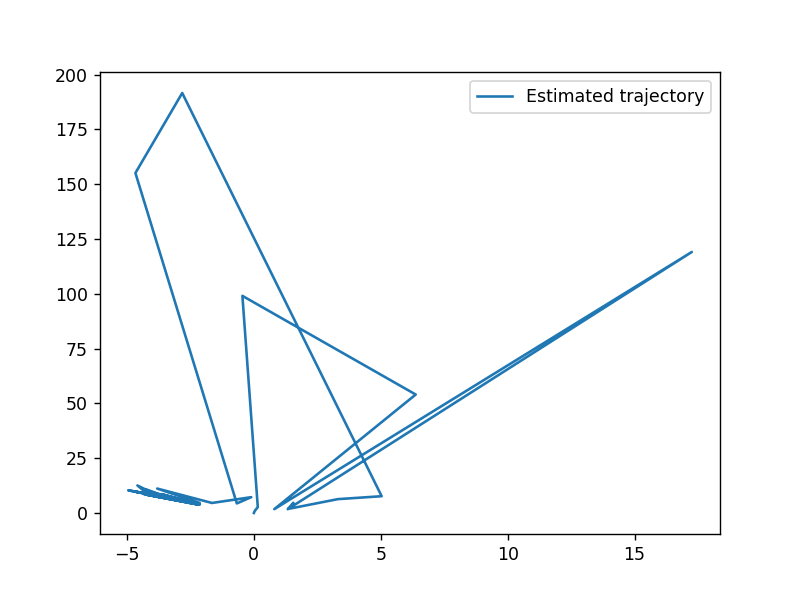

In [59]:
x0 = []
y0 = []
for i in range(len(translations)-1):
    y0.append(-1*translations[i][2])
    x0.append(translations[i][0])
fig,axes = plt.subplots()
axes.plot(x0,y0,label = 'Estimated trajectory')
axes.legend()
plt.show()

In [60]:
translations1 = []
translations1.append(np.zeros((3,1)))
rotations1 = []
rotations1.append(np.identity(3))
scale1 = []
pointcloud = []
error_set = []

for a in range(len(L)-2):
    old_cloud = pointcloud
    img1 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(dataset_location +'/'+ L[a+1],cv.IMREAD_GRAYSCALE)
    pts,kp1= keypoints(img1)
    kp2,kp1 = optical_flow_matches(img2,img1,kp1,10)
    E, mask = cv.findEssentialMat(kp2,kp1,k,cv.RANSAC, prob = 0.999,threshold = 0.4,mask=None)

    #inlier points
    pts1 = kp1[mask.ravel()==1]
    pts2 = kp2[mask.ravel()==1]

    #recovering pose info
    retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
    
    if a == 0:
        R1 = np.identity(3)
        t1 = np.zeros((3,1))
        print(t1.shape)
        pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
        retval, rvec, t, inliers = cv.solvePnPRansac(pointcloud,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.50,flags = 1)
        R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
        translations1.append(t)
        print(t)
        rotations1.append(R)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))
        
    elif a == len(L)-2:
        R1 = np.identity(3)
        t1 = np.zeros((3,1))
        print(t1.shape)
        pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
        retval, rvec, t, inliers = cv.solvePnPRansac(pointcloud,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.50,flags = 1)
        R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
        print(t)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t+ translations1[a])
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))
        
    else:
        R1 = np.identity(3)
        t1 = np.zeros((3,1))
        print(t1.shape)
        pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
        retval, rvec, t, inliers = cv.solvePnPRansac(pointcloud,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.50,flags = 1)
        R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R1,R,t1,t,pts1,pts2)
        print(t)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations1[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))

(3, 1)
[[-0.63313339]
 [ 0.89189492]
 [-2.67088477]]
0 0.08066814934373645
(3, 1)
[[ 0.02931231]
 [ 0.39291835]
 [-4.3477124 ]]
1 0.32526233823170336
(3, 1)
[[-3.65377850e-01]
 [-6.90525855e+00]
 [-1.00614578e+03]]
2 3.161257427355871
(3, 1)
[[-0.13766824]
 [-0.15475615]
 [61.44737493]]
3 9.831893292634124
(3, 1)
[[-0.0934318 ]
 [ 0.19443672]
 [-3.87873255]]
4 3.4963944547594616
(3, 1)
[[ 0.18673588]
 [ 0.1839801 ]
 [-3.61339542]]
5 9.457195822247517
(3, 1)
[[ 0.40199254]
 [-0.89277525]
 [ 3.33159515]]
6 5.908086867324625
(3, 1)
[[-0.07093606]
 [ 0.16813955]
 [-1.63845345]]
7 2.674594840144102
(3, 1)
[[ 0.00895193]
 [-0.69895877]
 [ 0.01179856]]
8 1.382333991830696
(3, 1)
[[ 0.05906098]
 [ 0.12773586]
 [-1.50081126]]
9 5.242822429475689
(3, 1)
[[-5.61327545]
 [-2.64086579]
 [25.64024719]]
10 2.215438767552235
(3, 1)
[[ 0.04528174]
 [ 0.01553125]
 [-1.10523757]]
11 5.571805566572856
(3, 1)
[[ 0.07442418]
 [ 0.02439142]
 [-1.24576652]]
12 5.498773186001645
(3, 1)
[[ 0.17459619]
 [ 0.0353

(3, 1)
[[ 0.10378811]
 [-0.02157012]
 [-1.06335536]]
109 10.461534161356557
(3, 1)
[[-0.79390996]
 [ 0.03549936]
 [ 0.5147898 ]]
110 58.26097828490659
(3, 1)
[[-0.11307295]
 [ 0.00156089]
 [-0.55643359]]
111 26.833802664331483
(3, 1)
[[ 0.08065524]
 [-0.01322807]
 [-0.22472161]]
112 13.480848400166545
(3, 1)
[[ 0.03409366]
 [-0.03256724]
 [ 1.78368805]]
113 42.98849447362003
(3, 1)
[[-0.10640627]
 [ 0.04028818]
 [-0.67881668]]
114 26.834599231881885
(3, 1)
[[0.07732498]
 [0.00651309]
 [1.02972395]]
115 4.915565470648858
(3, 1)
[[-0.13055899]
 [ 0.1863228 ]
 [-1.38079437]]
116 6.742443490662614
(3, 1)
[[ 0.12333573]
 [-0.00902595]
 [ 0.56003048]]
117 42.05072100698988
(3, 1)
[[ 0.11272107]
 [-0.00228128]
 [ 0.66921812]]
118 23.629808140638506
(3, 1)
[[-2.11679957e-02]
 [-7.04522852e-03]
 [-7.57646633e+00]]
119 22.496802782278813
(3, 1)
[[-0.18952499]
 [ 0.17717691]
 [-1.11928176]]
120 22.169722708379886
(3, 1)
[[-0.00483394]
 [ 0.03331659]
 [ 0.1766453 ]]
121 2.771296501851082
(3, 1)
[[

<IPython.core.display.Javascript object>


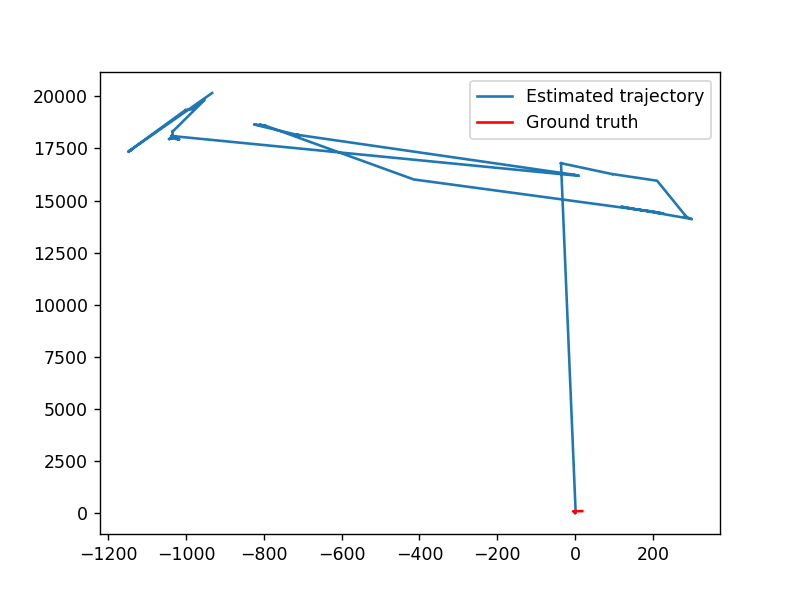

In [61]:
x0 = []
y0 = []
for i in range(len(translations1)-1):
    y0.append(translations1[i][2])
    x0.append(translations1[i][0])
fig,axes = plt.subplots()
axes.plot(x0,y0,label = 'Estimated trajectory')
axes.plot(gx, gz,color = 'red',label = 'Ground truth')
axes.legend()
plt.show()